In [1]:
!ls /kaggle/input/flickr8k

Images	captions.txt


In [2]:
#!conda install --yes -c pytorch pytorch=1.7.1 torchvision 
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://download.pytorch.org/whl/cu118
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/fd/84/fd2ba7aafacbad3c4201d395674fc6348826569da3c0937e75505ead3528/wcwidth-0.2.13-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstalling wcwidth-0.2.6:
      Successfully uninstalled wcwidth-0.2.6
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vcrfr8rw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vcrfr8rw
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Pr

In [3]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 67.1 MB/s eta 0:00:00


In [4]:
import torch
import clip
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import faiss
import cv2

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
#clip-vit-base-patch32
#model, preprocess = clip.load("ViT-L/14@336px", device=device)


100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 43.7MiB/s]


In [6]:
device

'cuda'

In [7]:
dataset_path = "/kaggle/input/flickr8k/Images/"

In [8]:
image_path = os.listdir(dataset_path)
image_df = pd.Series(image_path)
image_df = pd.DataFrame(image_df)
image_df.columns = ["file_name"]


In [9]:
image_df.head()

,file_name
0,3226254560_2f8ac147ea.jpg
1,214543992_ce6c0d9f9b.jpg
2,2366643786_9c9a830db8.jpg
3,3368819708_0bfa0808f8.jpg
4,2190227737_6e0bde2623.jpg


In [10]:
image_df.shape

(8091, 1)

In [11]:
image_df.to_csv("image_df.csv")

In [12]:
def extract_image_feature_vector(file_name, model):
    img = preprocess(Image.open(dataset_path+file_name)).unsqueeze(0).to(device)
    img_feature = model.encode_image(img)
    img_feature = img_feature.detach().cpu().numpy()
    return img_feature[0]
    
def extract_text_feature_vector(text, model):
    text = clip.tokenize([text]).to(device)
    text_feature = model.encode_text(text)
    text_feature = text_feature.detach().cpu().numpy()
    return text_feature[0]
    
    

In [13]:
image_df.shape[0]

8091

In [14]:
xb = []
for i in range(image_df.shape[0]):
#for i in range(100):
    xb.append(extract_image_feature_vector(image_df["file_name"][i], model))
xb = np.array(xb)
    

In [15]:
xb.shape

(8091, 512)

In [16]:
np.save("feature_vectors_vit_b32.npy", xb)

In [17]:
index = faiss.IndexFlatL2(512)
index.add(xb)
print(index.ntotal)

8091


In [18]:
query = "the cat"

In [19]:
xq = []
xq.append(extract_text_feature_vector(query, model))
xq = np.array(xq)


In [20]:
D, I = index.search(xq, 15)


In [21]:
I

array([[4102,  772, 6806, 7405, 4456, 6941, 2302,  607, 2986, 6220, 4046,
        3111, 2756, 1987, 5860]])

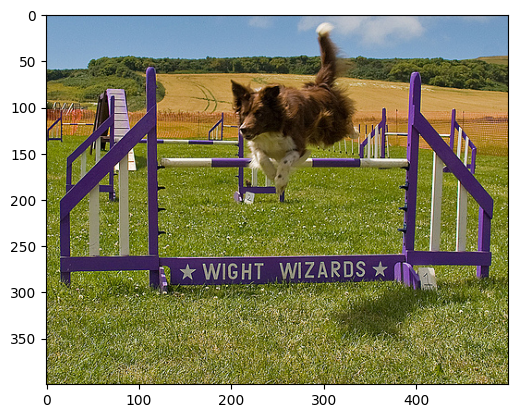

In [22]:
img = cv2.imread(dataset_path + image_df["file_name"][I[0][9]])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)